# Interactive Bath Model Analysis

This notebook provides an interactive analysis of different bosonic bath models used in quantum optics and open quantum systems. It allows comparison between different bath types and their spectral properties.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Bath Model Definitions](#definitions)
3. [Interactive Parameter Controls](#controls)
4. [Bath Comparison Analysis](#comparison)
5. [Temperature Effects](#temperature)
6. [Correlation Function Analysis](#correlation)

### Discussion: Units of Spectral Density in Different Conventions
$J(\omega)$ describes the spectral density of environmental modes at a given frequency $\omega$ and how strongly these modes couple to the system.
In the [paper](https://pubs.aip.org/aip/jcp/article/124/23/234505/930637/Two-dimensional-optical-three-pulse-photon-echo), **spectroscopic units of cm⁻¹** are used for transition frequencies ("wavenumbers"). The spectral density is defined as:
$$
J(\omega) = \alpha^2 \frac{\omega}{\omega_c} \exp\left(-\frac{\omega}{\omega_c}\right)
$$
where:
- $\alpha$ is the dimensionless coupling strength,
- $\omega_c$ is the cutoff frequency,
- $\omega$ is the frequency.

**Units:**  
- $J(\omega)$ is dimensionless in this context.


In **QuTiP**, the Ohmic spectral density is typically written as:
$$
J(\omega) = \alpha \frac{\omega^s}{\omega_c^{s-1}} \exp\left(-\frac{\omega}{\omega_c}\right)
$$
For the Ohmic case ($s = 1$):
$$
J(\omega) = \alpha \omega \exp\left(-\frac{\omega}{\omega_c}\right)
$$
where:
- $\alpha$ is the dimensionless coupling strength,
- $\omega_c$ is the cutoff frequency,
- $\omega$ is the frequency.

**Units:**  
- $J(\omega)$ now has units of frequency ($[\omega]$).


#### Physical Meaning

According to [Wikipedia](https://en.wikipedia.org/wiki/Spectral_density), the spectral density $J(\omega)$ represents the **amount of Power per unit frequency range**. ---

**References:**  
- Weiss, U. (2012). Quantum Dissipative Systems.

$$
H_{\text{SB}} = \Sigma_i F_i Aᵢ
$$

$$
[\mathbf{A}_i] = \left[\mu\right] = 1  \quad \text{(dimensionless (in the paper))}
$$

$$
[H_{\text{SB}}] = \left[J\right] = \left[eV\right]
$$

Then:
$$
[F_i] = \left[ J\right] = \left[eV\right]
$$

And:
$$
[g_x^i] = \left[ J\right] = \left[eV\right] = \left[ \omega\right] \text{(because [HBAR]=1)}
$$

$$
[J_i(\omega)] = [g_x^{i\,2} \, \delta(\omega)] = \left[\omega\right] \text{(matches the Qutip definition)}
$$
But now:
$$
[J(\omega)] = [\alpha^2] ?=? \left[\omega^2\right]
$$


**Actually the coupling constant in the paper is Not dimensionless**


## Bath Model Definitions

We analyze three main types of bosonic baths:

1. **Paper Bath**: Exponential cutoff spectral density as used in the research paper
2. **Ohmic Bath**: Power-law spectral density with exponential cutoff  
3. **Drude-Lorentz Bath**: Lorentzian spectral density commonly used in condensed matter

Each bath is characterized by its spectral density $J(\omega)$ and Power spectrum $S(\omega)$.

In [44]:
# Global plotting style for the entire notebook
from qspectro2d.config.paths import FIGURES_TESTS_DIR
name_plot_folder = "test_baths"
custom_dir = FIGURES_TESTS_DIR / name_plot_folder

from plotstyle.style import init_style, COLORS, LINE_STYLES, MARKERS
# Initialize matplotlib/LaTeX style once
init_style(quiet=True)
# =============================
# BATH MODEL CONSTANTS AND PARAMETERS (UPDATED)
# =============================
# Default parameter sets for different bath types
cutoff = 100.0   # Bath cutoff frequency
temp   = 0.01    # Bath temperature
alpha  = 0.01    # Coupling strength
s      = 1.0     # Ohmicity parameter
args = {
    "cutoff": cutoff,
    "temp": temp,
    "alpha": alpha,
    "s": s
}
from qspectro2d.core.bath_system.bath_fcts import spectral_density_func_drude_lorentz, power_spectrum_func_drude_lorentz, spectral_density_func_ohmic, power_spectrum_func_ohmic, spectral_density_func_paper, power_spectrum_func_paper
from qutip import BosonicEnvironment, OhmicEnvironment
import numpy as np
import matplotlib.pyplot as plt

# Display default bath parameters
print("🔧 Default bath parameters loaded:")
print(f"   Temperature: {temp:.1e}")
print(f"   Coupling α: {alpha:.1e}")
print(f"   Cutoff: {cutoff:.1e}")

🔧 Default bath parameters loaded:
   Temperature: 1.0e-02
   Coupling α: 1.0e-02
   Cutoff: 1.0e+02


In [45]:
# SEPARATE AXIS PLOTS FOR PAPER, OHMIC, AND DRUDE-LORENTZ BATHS
# =============================
Lorentzian_env = BosonicEnvironment.from_spectral_density(
    lambda w: spectral_density_func_drude_lorentz(w, cutoff=cutoff, temp=temp, alpha=alpha),
    wMax=10 * cutoff,
    T=temp
)

# Frequency range for each bath
omega = np.linspace(-5 * cutoff, 5 * cutoff, 500)

# Time axes for correlation functions
times = np.linspace(-2 / cutoff, 2 / cutoff, 500)

# Power spectrum and spectral density for each bath
P_vals_paper = power_spectrum_func_paper(omega, cutoff=cutoff, temp=temp, alpha=alpha)
J_vals_paper = spectral_density_func_paper(omega, cutoff=cutoff, temp=temp, alpha=alpha)
P_vals_drude_lorentz = Lorentzian_env.power_spectrum(omega)
J_vals_drude_lorentz = spectral_density_func_drude_lorentz(omega, cutoff=cutoff, temp=temp, alpha=alpha)

bath_ohmic = OhmicEnvironment(
    T=temp,
    wc=cutoff,
    s=s,
    alpha=alpha
)
spec_fct_ohmic = bath_ohmic.spectral_density
P_fct_ohmic = bath_ohmic.power_spectrum

P_vals_ohmic = P_fct_ohmic(omega)
J_vals_ohmic = spec_fct_ohmic(omega)

corr_paper = BosonicEnvironment.from_power_spectrum(
    lambda w: power_spectrum_func_paper(w, cutoff=cutoff, temp=temp, alpha=alpha),
    wMax=10 * cutoff,
    T=temp
).correlation_function(times)
corr_ohmic = bath_ohmic.correlation_function(times)
corr_DL = Lorentzian_env.correlation_function(times)

# ...existing code for plotting...

## Interactive Parameter Controls

Use the controls below to explore how different parameters affect the bath properties:

## Temperature Effects Analysis

Explore how temperature affects the bath properties, particularly the Power spectrum and correlation functions:

🌡️ Analyzing temperature effects...


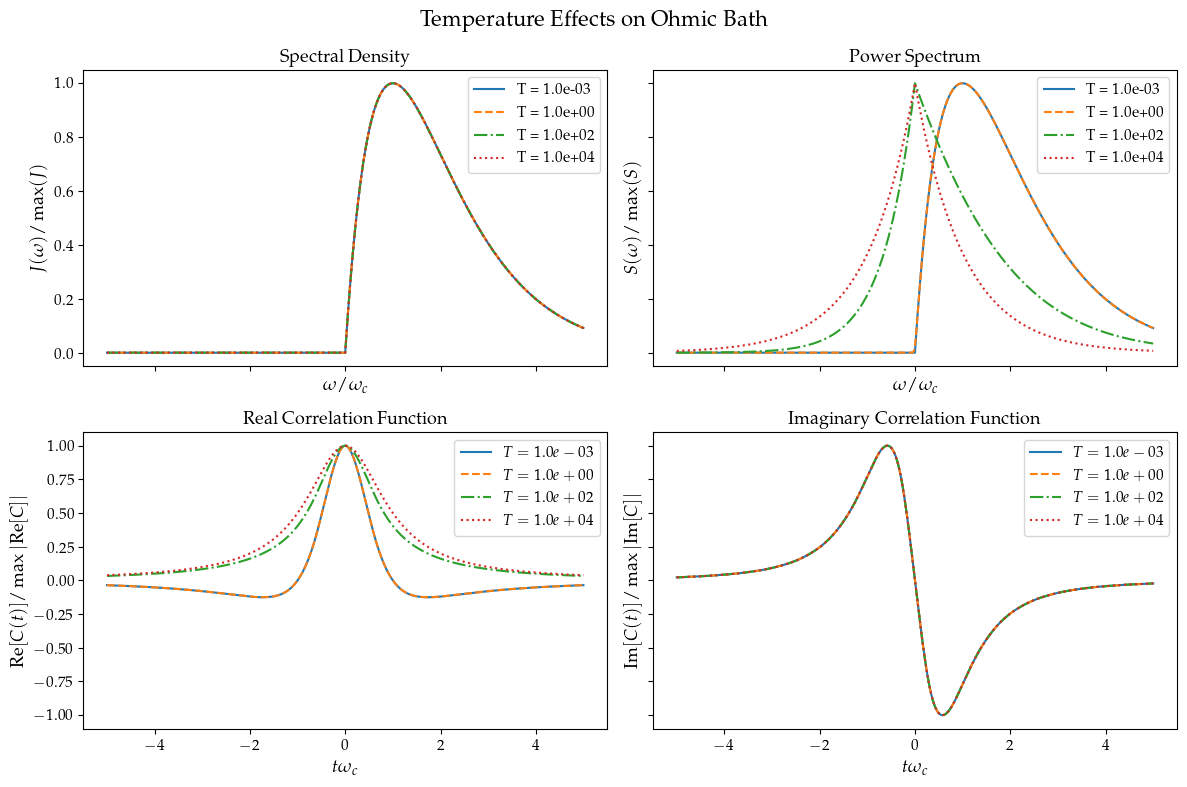

In [46]:
# =============================
# TEMPERATURE EFFECTS ANALYSIS (UPDATED FOR NEW API)
# =============================

from plotstyle.style import save_fig


def analyze_temperature_effects(bath_type='Paper Bath', temperatures=None):
    """Analyze how temperature affects bath properties"""
    if temperatures is None:
        temperatures = [1e-3, 1, 1e2, 1e4]

    cutoff = 1e2
    alpha  = 1e-2
    frequencies = np.linspace(-5 * cutoff, 5 * cutoff, 10001)
    times       = np.linspace(-5 / cutoff, 5 / cutoff, 10001)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='col', sharey='row')
    fig.suptitle(f'Temperature Effects on {bath_type}', fontsize=16, fontweight='bold')
    
    for i, temp in enumerate(temperatures):
        color     = COLORS[i % len(COLORS)]
        linestyle = LINE_STYLES[i % len(LINE_STYLES)]
        if bath_type == 'Paper Bath':
            J_func = spectral_density_func_paper
            S_func = power_spectrum_func_paper
        elif bath_type == 'Ohmic Bath':
            J_func = spectral_density_func_ohmic
            S_func = power_spectrum_func_ohmic
        else:
            J_func = spectral_density_func_drude_lorentz
            S_func = power_spectrum_func_drude_lorentz

        local_args = dict(cutoff=cutoff, temp=temp, alpha=alpha, s=1.0)

        # Calculate spectral density and Power spectrum
        J_vals = np.array([J_func(w, **local_args) for w in frequencies])
        S_vals = np.array([S_func(w, **local_args) for w in frequencies])
        
        # Plot spectral density (normalized)
        J_pos = J_vals[J_vals > 0]
        J_max = np.max(np.abs(J_pos)) if J_pos.size else 1.0
        axes[0, 0].plot(
            frequencies / cutoff,
            J_vals / J_max,
            color=color,
            linestyle=linestyle,
            label=f'T = {temp:.1e}'
        )
        
        # Plot Power spectrum (normalized)
        S_max = np.max(np.abs(S_vals)) if np.any(S_vals != 0) else 1.0
        axes[0, 1].plot(
            frequencies / cutoff,
            S_vals / S_max,
            color=color,
            linestyle=linestyle,
            label=f'T = {temp:.1e}'
        )
        
        # Correlation via QuTiP
        try:
            if bath_type == 'Paper Bath':
                env = BosonicEnvironment.from_power_spectrum(
                    lambda w: power_spectrum_func_paper(w, **local_args), wMax=10 * cutoff, T=temp
                )
            else:
                env = BosonicEnvironment.from_spectral_density(
                    lambda w: J_func(w, **local_args), wMax=10 * cutoff, T=temp
                )
            correlation_vals = env.correlation_function(times)

            # Plot real part of correlation function
            C_max = np.max(np.abs(np.real(correlation_vals)))
            if C_max > 0:
                axes[1, 0].plot(
                    times * cutoff,
                    np.real(correlation_vals) / C_max,
                    color=color,
                    linestyle=linestyle,
                    label=fr'$T = {temp:.1e}$'
                )

            # Plot imaginary part of correlation function
            C_imax = np.max(np.abs(np.imag(correlation_vals)))
            if C_imax > 0:
                axes[1, 1].plot(
                    times * cutoff,
                    np.imag(correlation_vals) / C_imax,
                    color=color,
                    linestyle=linestyle,
                    label=fr'$T = {temp:.1e}$'
                )
        except Exception as e:
            print(f"QuTiP error for T={temp}: {e}")
    
    # Set labels and titles
    axes[0, 0].set_xlabel(r'$\omega / \omega_c$')
    axes[0, 0].set_ylabel(r'$J(\omega) / \max(J)$')
    axes[0, 0].set_title('Spectral Density')
    axes[0, 0].legend()
    
    axes[0, 1].set_xlabel(r'$\omega / \omega_c$')
    axes[0, 1].set_ylabel(r'$S(\omega) / \max(S)$')
    axes[0, 1].set_title('Power Spectrum')
    axes[0, 1].legend()
    
    axes[1, 0].set_xlabel(r'$t \omega_c$')
    axes[1, 0].set_ylabel(r'$\mathrm{Re}[C(t)] / \max|\mathrm{Re}[C]|$')
    axes[1, 0].set_title('Real Correlation Function')
    axes[1, 0].legend()

    axes[1, 1].set_xlabel(r'$t \omega_c$')
    axes[1, 1].set_ylabel(r'$\mathrm{Im}[C(t)] / \max|\mathrm{Im}[C]|$')
    axes[1, 1].set_title('Imaginary Correlation Function')
    axes[1, 1].legend()

    plt.tight_layout()
    return fig, axes

# Create temperature analysis
print("🌡️ Analyzing temperature effects...")
fig_temp, axes_temp = analyze_temperature_effects('Ohmic Bath')
save_fig(fig_temp, custom_dir / "temperature_analysis_ohmic_bath")

### Physical Interpretation:
- **Weak coupling regime**: $α ≪ 1$ ensures validity of Born-Markov approximation
- **High temperature**: Classical limit where $S(ω) ≈ S(-ω)$
- **Low temperature**: Quantum regime with strong frequency asymmetry

In [47]:
# =============================
# INTERACTIVE BATH ANALYSIS WITH CORRELATION FUNCTIONS
# =============================
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from qutip import BosonicEnvironment, OhmicEnvironment
from IPython.display import display, clear_output


def create_interactive_controls():
    """Create interactive widgets for parameter exploration"""
    temp_slider = widgets.FloatLogSlider(
        value=0.01,
        base=10,
        min=-4, max=2,
        step=0.1,
        description='Temperature:',
        readout_format='.2e',
        style={'description_width': 'initial'}
    )
    eta_slider = widgets.FloatLogSlider(
        value=0.01,
        base=10,
        min=-4, max=0,
        step=0.1,
        description='Coupling $\alpha$:',
        readout_format='.2e',
        style={'description_width': 'initial'}
    )
    cutoff_slider = widgets.FloatLogSlider(
        value=100.0,
        base=10,
        min=0, max=3,
        step=0.1,
        description='Cutoff $\omega_c$:',
        readout_format='.1e',
        style={'description_width': 'initial'}
    )
    freq_range_slider = widgets.FloatRangeSlider(
        value=[-0.5, 5],
        min=-2, max=10,
        step=0.5,
        description='Freq Range:',
        style={'description_width': 'initial'}
    )
    bath_selector = widgets.SelectMultiple(
        options=['Paper Bath', 'Ohmic Bath', 'Drude-Lorentz'],
        value=['Paper Bath', 'Ohmic Bath', 'Drude-Lorentz'],
        description='Bath Types:',
        style={'description_width': 'initial'}
    )
    return temp_slider, eta_slider, cutoff_slider, freq_range_slider, bath_selector


def interactive_comprehensive_bath_analysis(temp, alpha, cutoff, freq_range, selected_baths):
    """Interactive plotting function for comprehensive bath analysis with correlation functions"""
    clear_output(wait=True)
    omega = np.linspace(freq_range[0] * cutoff, freq_range[1] * cutoff, 500)
    times = np.linspace(0, 2 / cutoff, 500)

    bath_data = {}
    for bath_name in selected_baths:
        if bath_name == 'Paper Bath':
            bath_data[bath_name] = {
                'J_func': lambda w: spectral_density_func_paper(w, cutoff=cutoff, temp=temp, alpha=alpha),
                'S_func': lambda w: power_spectrum_func_paper(w, cutoff=cutoff, temp=temp, alpha=alpha)
            }
            bath_data[bath_name]['env'] = BosonicEnvironment.from_power_spectrum(
                lambda w: power_spectrum_func_paper(w, cutoff=cutoff, temp=temp, alpha=alpha),
                wMax=10 * cutoff,
                T=temp
            )
        elif bath_name == 'Ohmic Bath':
            bath_ohmic = OhmicEnvironment(
                T=temp,
                wc=cutoff,
                s=1.0,
                alpha=alpha
            )
            bath_data[bath_name] = {
                'J_func': lambda w: spectral_density_func_ohmic(w, cutoff=cutoff, temp=temp, alpha=alpha, s=1.0),
                'S_func': lambda w: bath_ohmic.power_spectrum(w),
                'env': bath_ohmic
            }
        else:
            bath_data[bath_name] = {
                'J_func': lambda w: spectral_density_func_drude_lorentz(w, cutoff=cutoff, temp=temp, alpha=alpha),
                'S_func': lambda w: power_spectrum_func_drude_lorentz(w, cutoff=cutoff, temp=temp, alpha=alpha)
            }
            bath_data[bath_name]['env'] = BosonicEnvironment.from_spectral_density(
                lambda w: spectral_density_func_drude_lorentz(w, cutoff=cutoff, temp=temp, alpha=alpha),
                wMax=10 * cutoff,
                T=temp
            )

    # Evaluate arrays
    for bath_name, bath in bath_data.items():
        bath['J_vals'] = np.array([bath['J_func'](w) for w in omega])
        bath['P_vals'] = np.array([bath['S_func'](w) for w in omega])
        bath['corr']   = bath['env'].correlation_function(times)

    # Choose reference for normalization
    ref_bath = 'Ohmic Bath' if 'Ohmic Bath' in bath_data else list(bath_data.keys())[0]
    J_max_ref = np.max(np.abs(bath_data[ref_bath]['J_vals'])) if np.any(bath_data[ref_bath]['J_vals'] != 0) else 1.0
    P_max_ref = np.max(np.abs(bath_data[ref_bath]['P_vals'])) if np.any(bath_data[ref_bath]['P_vals'] != 0) else 1.0
    C_max_ref = np.max(np.abs(bath_data[ref_bath]['corr']))   if np.any(bath_data[ref_bath]['corr'] != 0)   else 1.0

    fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharex='col')
    fig.suptitle(rf'Bath Analysis: T={temp:.1e}, $\alpha$={alpha:.1e}, $\omega_c$={cutoff:.1e}', fontsize=16, fontweight='bold')

    for i, bath_name in enumerate(selected_baths):
        if i >= 3:
            break
        color     = COLORS[i % len(COLORS)]
        linestyle = LINE_STYLES[i % len(LINE_STYLES)]
        linewidth = 2

        J_vals = bath_data[bath_name]['J_vals'] / J_max_ref
        P_vals = bath_data[bath_name]['P_vals'] / P_max_ref
        corr   = bath_data[bath_name]['corr']   / C_max_ref

        axes[i, 0].plot(
            omega / cutoff, J_vals,
            label=fr"$J(\omega)$",
            color=color, linestyle=linestyle, linewidth=linewidth
        )
        axes[i, 0].set_ylabel(fr"$J(\omega) / \max J_{{\mathrm{{{ref_bath.split()[0]}}}}}$")
        axes[i, 0].set_title(f"Spectral Density ({bath_name})")
        axes[i, 0].legend()

        axes[i, 1].plot(
            omega / cutoff, P_vals,
            label=fr"$P(\omega)$",
            color=color, linestyle=linestyle, linewidth=linewidth
        )
        axes[i, 1].set_ylabel(fr"$P(\omega) / \max P_{{\mathrm{{{ref_bath.split()[0]}}}}}$")
        axes[i, 1].set_title(f"Power Spectrum ({bath_name})")
        axes[i, 1].legend()

        axes[i, 2].plot(
            times * cutoff, np.real(corr),
            label=fr"$\mathrm{{Re}}[C(t)]$",
            color=color, linestyle='solid', linewidth=linewidth
        )
        axes[i, 2].plot(
            times * cutoff, np.imag(corr),
            label=fr"$\mathrm{{Im}}[C(t)]$",
            color=COLORS[(i+2) % len(COLORS)], linestyle='dashed', linewidth=linewidth
        )
        axes[i, 2].set_ylabel(fr"$C(t) / \max |C_{{\mathrm{{{ref_bath.split()[0]}}}}}|$")
        axes[i, 2].set_title(f"Correlation Function ({bath_name})")
        axes[i, 2].legend()

    for ax in axes[2, :]:
        if ax == axes[2, 0]:
            ax.set_xlabel(r"$\omega / \omega_c$")
        elif ax == axes[2, 1]:
            ax.set_xlabel(r'$\omega / \omega_c$')
        else:
            ax.set_xlabel(r'$t \omega_c$')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    print(f"🔍 Analysis complete for: {', '.join(selected_baths)}")
    print(f"   Reference bath for normalization: {ref_bath}")


temp_slider, eta_slider, cutoff_slider, freq_range_slider, bath_selector = create_interactive_controls()
print("🎛️ Interactive Bath Analysis Controls:")
display(widgets.VBox([
    widgets.HBox([temp_slider, eta_slider]),
    widgets.HBox([cutoff_slider, freq_range_slider]),
    bath_selector
]))
interactive_plot = widgets.interactive(
    interactive_comprehensive_bath_analysis,
    temp=temp_slider,
    alpha=eta_slider,
    cutoff=cutoff_slider,
    freq_range=freq_range_slider,
    selected_baths=bath_selector
)
display(interactive_plot)

🎛️ Interactive Bath Analysis Controls:


interactive(children=(FloatLogSlider(value=0.01, description='Temperature:', max=2.0, min=-4.0, readout_format…

## Compare the BR to the ME solver in QuTiP

In [48]:
### THIS VERSION WORKS ONLY FOR OHMIC BATHS
def ohmic_alpha_to_rate(alpha: float, env: OhmicEnvironment, w0: float = None, mode: str = "decay") -> tuple[float, float] | float:
    """
    Wrapper to convert bath coupling constant alpha to ME rates.
    Args:
        alpha: Coupling constant of the bath.
        env: OhmicEnvironment instance with the bath parameters.
        w0: System frequency (required for decay mode).
        mode: 'decay' for decay rates, 'deph' for dephasing rate.
    Returns:
        Decay rates (gamma_emission, gamma_absorption) or dephasing rate (gamma_deph).
    """
    if mode == "decay":
        if w0 is None:
            raise ValueError("System frequency w0 must be provided for decay mode.")
        return ohmic_alpha_to_decay_rates(alpha, env, w0)
    elif mode == "deph":
        return ohmic_alpha_to_dephasing_rate(alpha, env)
    else:
        raise ValueError("Invalid mode. Use 'decay' or 'deph'.")

def ohmic_rate_to_alpha(rate: float | tuple[float, float], env: OhmicEnvironment, w0: float = None, wc=None, mode: str = "decay") -> float:
    """
    Wrapper to convert ME rates to bath coupling constant alpha.
    Args:
        rate: Decay rates (gamma_emission, gamma_absorption) or dephasing rate (gamma_deph).
        env: OhmicEnvironment instance with the bath parameters.
        w0: System frequency (required for decay mode).
        mode: 'decay' for decay rates, 'deph' for dephasing rate.
    Returns:
        alpha: Coupling constant of the bath.
    """
    if wc is None:
        wc = w0
    if mode == "decay":
        return ohmic_decay_rate_to_alpha(rate, env, w0, wc)
    elif mode == "deph":
        if not isinstance(rate, float):
            raise ValueError("Rate must be a float (gamma_deph) for dephasing mode.")
        return ohmic_dephasing_rate_to_alpha(rate, env, wc)
    else:
        raise ValueError("Invalid mode. Use 'decay' or 'deph'.")

def ohmic_alpha_to_decay_rates(alpha: float, env: OhmicEnvironment, w0: float) -> tuple[float, float]:
    """
    Convert bath coupling constant alpha to ME decay channel rates.
    Args:
        alpha: Coupling constant of the bath.
        env: OhmicEnvironment instance with the bath parameters.
        w0: System frequency.
    Returns:
        gamma_emission: Spontaneous emission rate.
        gamma_absorption: Thermal absorption rate.
    """
    env.alpha = alpha
    P_plus = env.power_spectrum(w0)   # S(+ω) - emission rate
    P_minus = env.power_spectrum(-w0) # S(-ω) - absorption rate
    gamma_emission = np.sqrt(P_plus)
    gamma_absorption = np.sqrt(P_minus)
    return gamma_emission, gamma_absorption

def ohmic_decay_rate_to_alpha(gamma_emission: float, env: OhmicEnvironment, w0: float, wc: float) -> float:
    """
    Convert ME decay channel rates to bath coupling constant alpha.
    Args:
        gamma_emission: Spontaneous emission rate.
        gamma_absorption: Thermal absorption rate.
        env: OhmicEnvironment instance with the bath parameters.
        w0: System frequency.
    Returns:
        alpha: Coupling constant of the bath.
    """
    # Avoid division by zero if w0 is very small
    if w0 < 1e-12:
        raise ValueError("w0 is too small; cannot determine alpha reliably.")

    temp = env.T

    P_plus = gamma_emission**2
    # Invert power spectrum to find alpha
    from qspectro2d.config import BOLTZMANN, HBAR
    w_th = BOLTZMANN * temp / HBAR
    coth_term = 1 / np.tanh(w0 / (2 * w_th))
    alpha = P_plus / (w0 * np.exp(-w0 / wc) * (coth_term + 1))

    return alpha

def ohmic_alpha_to_dephasing_rate(alpha: float, env: OhmicEnvironment) -> float:
    """
    Convert bath coupling constant alpha to ME dephasing rate.
    Args:
        alpha: Coupling constant of the bath.
        env: OhmicEnvironment instance with the bath parameters.
    Returns:
        gamma_deph: Pure dephasing rate.
    """
    print("now at0 freq 0 the PowerSpec is", env.power_spectrum(0))
    env.alpha = alpha
    P_zero = env.power_spectrum(0)  # S(0) - dephasing rate
    print("at freq 0 the PowerSpec is", P_zero)
    gamma_deph = np.sqrt(P_zero)
    return gamma_deph

def ohmic_dephasing_rate_to_alpha(gamma_deph: float, env: OhmicEnvironment, wc: float) -> float:
    """
    Convert ME dephasing rate to bath coupling constant alpha.
    Args:
        gamma_deph: Pure dephasing rate.
        env: OhmicEnvironment instance with the bath parameters.
    Returns:
        alpha: Coupling constant of the bath.
    """
    from qspectro2d.config import BOLTZMANN
    temp = env.T
    P_zero = gamma_deph**2
    alpha = P_zero / (2 * BOLTZMANN * temp)

    return alpha

At ω=0, P(ω)=4.01e-02


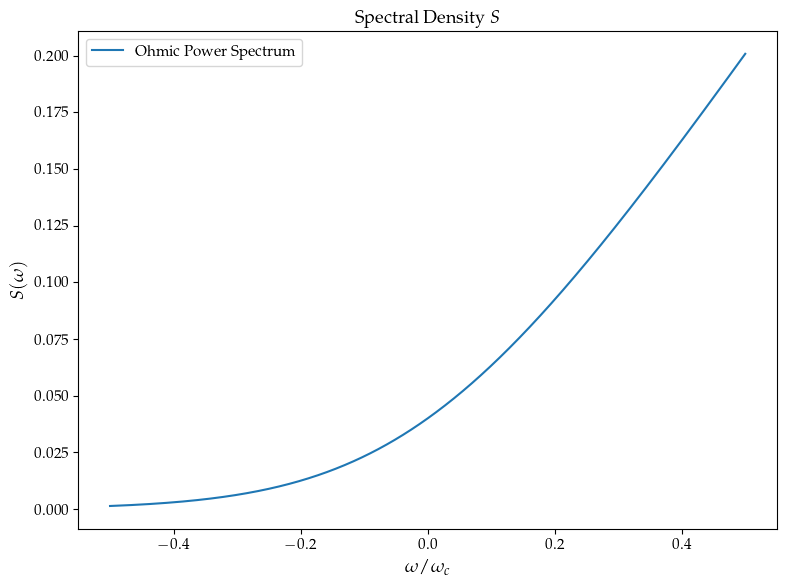

In [57]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
# =============================
# SYSTEM PARAMETERS
# =============================
g = basis(2, 0) 
e = basis(2, 1)  # Ground and excited states

w0 = 2   # Transition frequency
H0 = w0 * ket2dm(e) # Hamiltonian: H = w0 |e⟩⟨e|

sigma_minus = g * e.dag()  # |g⟩⟨e| - lowering operator
sigma_plus  = e * g.dag()  # |e⟩⟨g| - raising operator

sigma_x = (sigma_minus + sigma_plus)  # σ_x operator for system-bath coupling
sigma_z = (e * e.dag() - g * g.dag())  # σ_z operator for system-bath coupling

# =============================
# BATH PARAMETERS
# =============================
temp  = 1e-1  # Temperature in Kelvin
cutoff = 1e2 * w0  # Cutoff frequency in cm^-1
alpha = 1e-1 * w0  # Coupling strength
ohm_env_decay = OhmicEnvironment(T=temp, wc=cutoff, s=1.0, alpha=alpha, tag='ohmic')
ohm_env_deph  = OhmicEnvironment(T=temp, wc=cutoff, s=1.0, alpha=alpha, tag='ohmic')

omega = np.linspace(-5e-1, 5e-1, 1000)  # Frequency
power_spectrum_vals = ohm_env_decay.power_spectrum(omega)
print("At ω=0, P(ω)=%.2e" % power_spectrum_vals[500])  # Print power spectrum at ω=0

plt.figure()
plt.plot(omega, power_spectrum_vals, label='Ohmic Power Spectrum', color=COLORS[0])
plt.xlabel(r'$\omega / \omega_c$') # Use LaTeX math formatting for Greek letters
plt.ylabel(r'$S(\omega)$') # Example: update ylabel as well
plt.title(r'Spectral Density $S$') # Update title
plt.legend()
save_fig(plt.gcf(), custom_dir / "ohmic_power_spectrum")

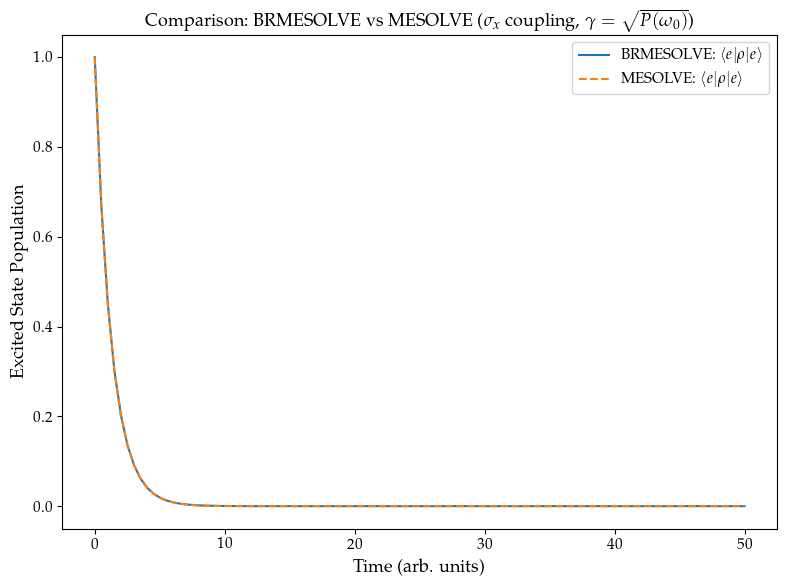

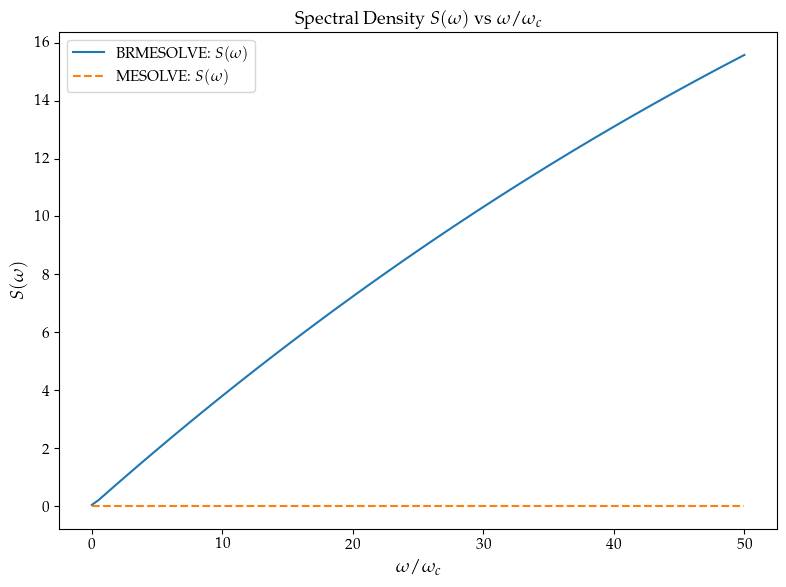

In [50]:
psi_ini    = ket2dm(e) # Initial state: excited state |e⟩⟨e|
tlist      = np.linspace(0, 50, 100) # Time array

# =============================
# BRMESOLVE SIMULATION
# =============================
a_ops_brme_decay = [ [sigma_x, lambda w: ohm_env_decay.power_spectrum(w)] ] # Use sigma_x as system-bath coupling

result_brme_decay = brmesolve(H0, psi_ini, tlist, a_ops_brme_decay)

# =============================
# MESOLVE SIMULATION
# =============================
### Extract power spectrum at system frequency
gamma_emission   = ohmic_alpha_to_rate(alpha, ohm_env_decay, w0=w0, mode="decay")[0]  # Spontaneous emission rate
gamma_absorption = ohmic_alpha_to_rate(alpha, ohm_env_decay, w0=w0, mode="decay")[1]  # Thermal absorption rate

### Collapse operators
c_ops_me_decay = [
    gamma_emission * sigma_minus,    # Emission: |e⟩ → |g⟩
    gamma_absorption * sigma_plus,   # Absorption: |g⟩ → |e⟩
]
result_me_decay = mesolve(H0, psi_ini, tlist, c_ops_me_decay)

# =============================
# PLOT COMPARISON
# =============================
plt.figure()

# Plot excited state population for brmesolve
pop_brme = [state[1, 1].real for state in result_brme_decay.states]
plt.plot(tlist, pop_brme, label=r"BRMESOLVE: $\langle e|\rho|e\rangle$", color=COLORS[0], linestyle=LINE_STYLES[0])

# Plot excited state population for mesolve
pop_me = [state[1, 1].real for state in result_me_decay.states]
plt.plot(tlist, pop_me, label=r"MESOLVE: $\langle e|\rho|e\rangle$", color=COLORS[1], linestyle=LINE_STYLES[1])

plt.xlabel(r"Time (arb. units)")
plt.ylabel(r"Excited State Population")
plt.title(r"Comparison: BRMESOLVE vs MESOLVE ($\sigma_x$ coupling, $\gamma = \sqrt{P(\omega_0)}$)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()

# =============================
# PLOT SPECTRAL DENSITY COMPARISON
# =============================

# BRMESOLVE spectral density
spec_brme_decay = [a_ops_brme_decay[0][1](freq) for freq in tlist]
plt.plot(tlist, spec_brme_decay, label=r"BRMESOLVE: $S(\omega)$", color=COLORS[0], linestyle=LINE_STYLES[0])

# MESOLVE spectral density
spec_me_decay = [gamma_emission if freq < 0 else gamma_absorption for freq in tlist]
plt.plot(tlist, spec_me_decay, label=r"MESOLVE: $S(\omega)$", color=COLORS[1], linestyle=LINE_STYLES[1])

plt.xlabel(r'$\omega / \omega_c$') # Use LaTeX math formatting for Greek letters
plt.ylabel(r'$S(\omega)$') # Example: update ylabel as well
plt.title(r'Spectral Density $S(\omega)$ vs $\omega / \omega_c$') # Update title
plt.legend()
plt.tight_layout()
plt.show()

add a part explaining the double hilbertspace and so on

now at0 freq 0 the PowerSpec is 0.04000000000000001
at freq 0 the PowerSpec is 0.04000000000000001


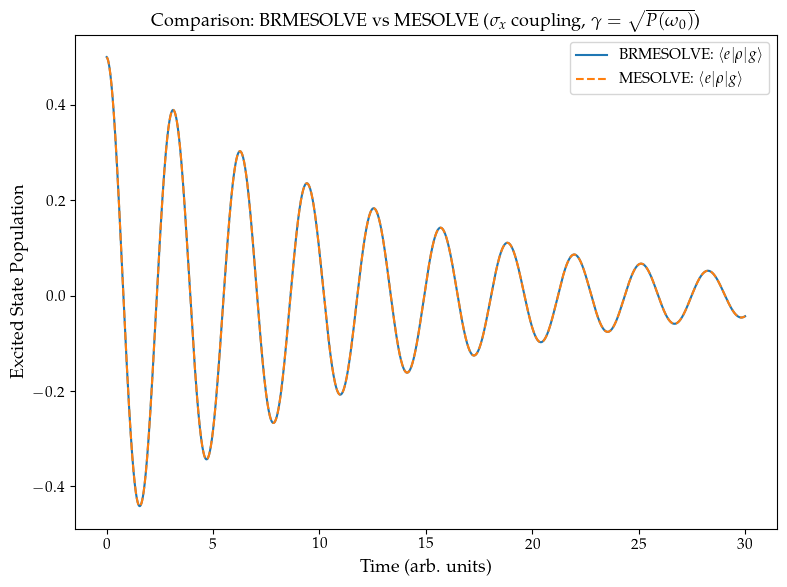

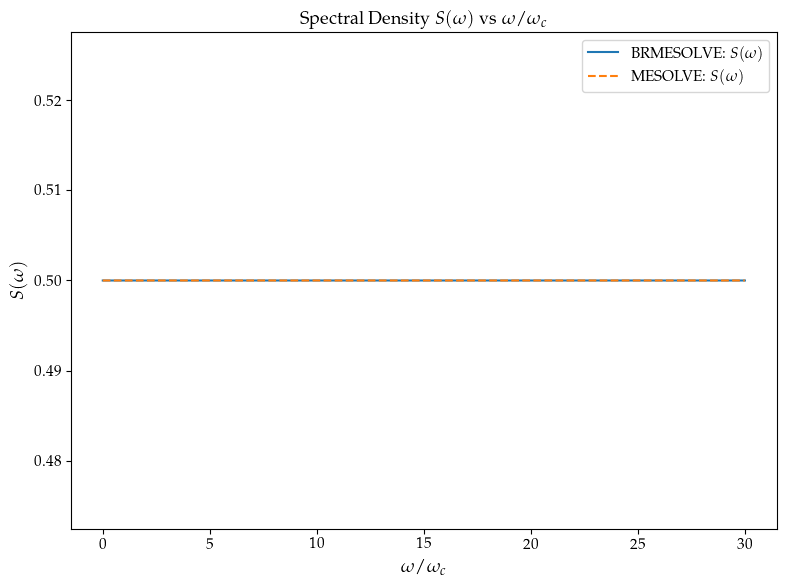

In [51]:
psi_ini    = (basis(2, 1) + basis(2, 0)).unit() # Initial state: excited state |e⟩⟨e|
tlist      = np.linspace(0, 30, 10000) # Time array

# =============================
# BRMESOLVE SIMULATION
# =============================
a_ops_brme_deph = [ [sigma_z, lambda w: ohm_env_deph.power_spectrum(w)] ] # Use sigma_z as system-bath coupling

result_brme_deph = brmesolve(H0, psi_ini, tlist, a_ops_brme_deph)

# =============================
# MESOLVE SIMULATION
# =============================
### Extract power spectrum at zero frequency for pure dephasing
gamma_deph = ohmic_alpha_to_rate(alpha, ohm_env_deph, mode="deph")  # Pure dephasing rate

### Collapse operators for pure dephasing
c_ops_me_deph = [gamma_deph * sigma_z]  # Pure dephasing collapse operator

result_me_deph = mesolve(H0, psi_ini, tlist, c_ops_me_deph)

# =============================
# PLOT COMPARISON
# =============================
plt.figure()

# Plot coherence for brmesolve
coh_brme = [state[0, 1].real for state in result_brme_deph.states]
plt.plot(tlist, coh_brme, label=r"BRMESOLVE: $\langle e|\rho|g\rangle$", color=COLORS[0], linestyle=LINE_STYLES[0])

# Plot coherence for mesolve
coh_me = [state[0, 1].real for state in result_me_deph.states]
plt.plot(tlist, coh_me, label=r"MESOLVE: $\langle e|\rho|g\rangle$", color=COLORS[1], linestyle=LINE_STYLES[1])

plt.xlabel(r"Time (arb. units)")
plt.ylabel(r"Excited State Population")
plt.title(r"Comparison: BRMESOLVE vs MESOLVE ($\sigma_x$ coupling, $\gamma = \sqrt{P(\omega_0)}$)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()

# Plot spectral density proxies for both
spec_brme = [state[0, 0].real for state in result_brme_deph.states]
plt.plot(tlist, spec_brme, label=r"BRMESOLVE: $S(\omega)$", color=COLORS[0], linestyle=LINE_STYLES[0])

spec_me = [state[0, 0].real for state in result_me_deph.states]
plt.plot(tlist, spec_me, label=r"MESOLVE: $S(\omega)$", color=COLORS[1], linestyle=LINE_STYLES[1])

plt.xlabel(r'$\omega / \omega_c$') # Use LaTeX math formatting for Greek letters
plt.ylabel(r'$S(\omega)$') # Example: update ylabel as well
plt.title(r'Spectral Density $S(\omega)$ vs $\omega / \omega_c$') # Update title
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
from qutip import operator_to_vector
from qspectro2d.core.simulation.builders import SimulationModuleOQS
from qspectro2d.core.simulation.config import SimulationConfig
from qspectro2d.core.atomic_system.system_class import AtomicSystem
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qutip import OhmicEnvironment

sim_config = SimulationConfig()
at_sys = AtomicSystem()
laser_sys = LaserPulseSequence.from_delays(
    delays=[1.0],
)
# Use QuTiP OhmicEnvironment directly
bath_env = OhmicEnvironment(alpha=0.01, T=0.01, wc=10.0, s=1.0)

sim_oqs = SimulationModuleOQS(
    simulation_config=sim_config,
    system=at_sys,
    laser=laser_sys,
    bath=bath_env,
)
# the code above in this cell is not needed for the rest of the notebook but kept as example
rho = basis(2, 0) * basis(2, 0).dag() + basis(2, 1) * basis(2, 0).dag()  # Initial density matrix
print(rho)
operator_to_vector(rho)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[1. 0.]
 [1. 0.]]


Quantum object: dims=[[[2], [2]], [1]], shape=(4, 1), type='operator-ket', dtype=CSR
Qobj data =
[[1.]
 [1.]
 [0.]
 [0.]]

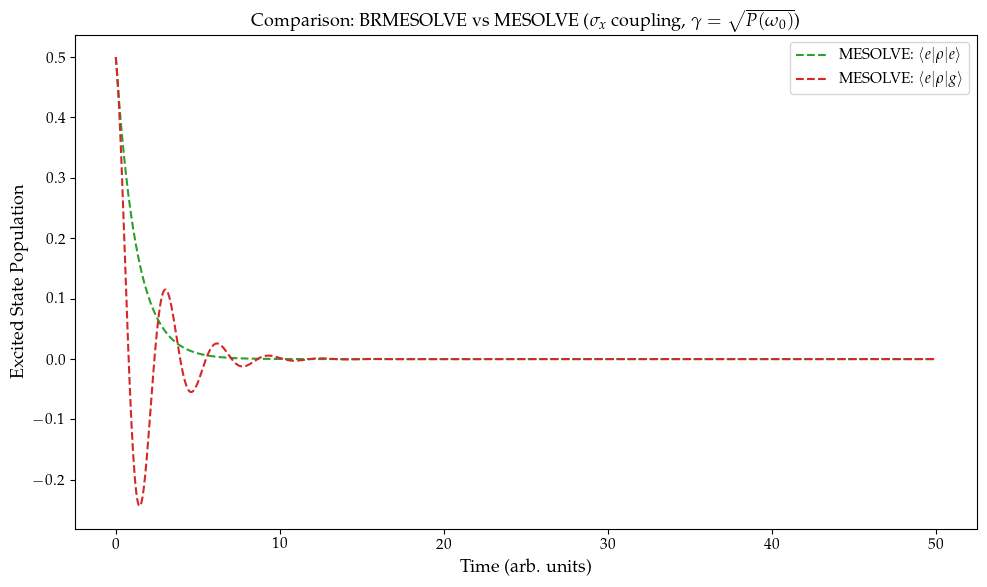

In [53]:
psi_ini= (basis(2, 1) + basis(2, 0)).unit() # Initial state: excited state |e⟩⟨e|

tlist = np.linspace(0, 50, 1000) # Time array

# =============================
# MESOLVE SIMULATION
# =============================
c_ops_me = c_ops_me_decay + c_ops_me_deph

result_me = mesolve(H0, psi_ini, tlist, c_ops_me)

# =============================
# PLOT COMPARISON
# =============================
plt.figure(figsize=(10, 6))

# Plot excited state population for mesolve
pop_me = [state[1, 1].real for state in result_me.states]
coh_me = [state[0, 1].real for state in result_me.states]  # Coherence |e><g|
plt.plot(tlist, pop_me, label=r"MESOLVE: $\langle e|\rho|e\rangle$", color=COLORS[2], linestyle=LINE_STYLES[1])
plt.plot(tlist, coh_me, label=r"MESOLVE: $\langle e|\rho|g\rangle$", color=COLORS[3], linestyle=LINE_STYLES[1])

plt.xlabel(r"Time (arb. units)")
plt.ylabel(r"Excited State Population")
plt.title(r"Comparison: BRMESOLVE vs MESOLVE ($\sigma_x$ coupling, $\gamma = \sqrt{P(\omega_0)}$)")
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
# BathSystem removed: use BosonicEnvironment, OhmicEnvironment, and direct bath function calls

# Demonstration of using unified conversion helpers for a generic BosonicEnvironment
# Instead of custom paper_alpha_to_* wrappers, use bath_to_rates / rates_to_alpha

def paper_alpha_to_rate(alpha: float, env: BosonicEnvironment, w0: float = None, mode: str = "decay"):
    env.alpha = alpha  # set coupling strength directly on environment (qutip Ohmic-like attr)
    if mode == 'decay':
        if w0 is None:
            raise ValueError("w0 required for decay mode")
        # bath_to_rates returns (emission, absorption) for decay
        return bath_to_rates(env, w0, mode='decay')
    elif mode == 'deph':
        return bath_to_rates(env, mode='deph')
    else:
        raise ValueError("mode must be 'decay' or 'deph'")

def paper_rate_to_alpha(rate, env: BosonicEnvironment, w0: float = None, wc=None, mode: str = 'decay'):
    # Delegate to existing helper; for current implementation rates_to_alpha expects emission rate + env.
    if mode == 'decay':
        if w0 is None or wc is None:
            raise ValueError("w0 and wc required for decay mode")
        emission_rate = rate if isinstance(rate, float) else rate[0]
        return rates_to_alpha(emission_rate, env, w=w0, wc=wc, mode='decay')
    elif mode == 'deph':
        if not isinstance(rate, float):
            raise ValueError("Provide scalar dephasing rate for deph mode")
        return rates_to_alpha(rate, env, mode='deph')
    else:
        raise ValueError("mode must be 'decay' or 'deph'")

## Compare zero frequency limit of the paper bath and the Ohmic bath

compare power spectrum at zero frequency:
Paper Bath Power Spectrum at ω=0: 2.00e-06 (from environment)
Paper Bath Power Spectrum at ω=0: 2.00e-06 (from function)
0.0


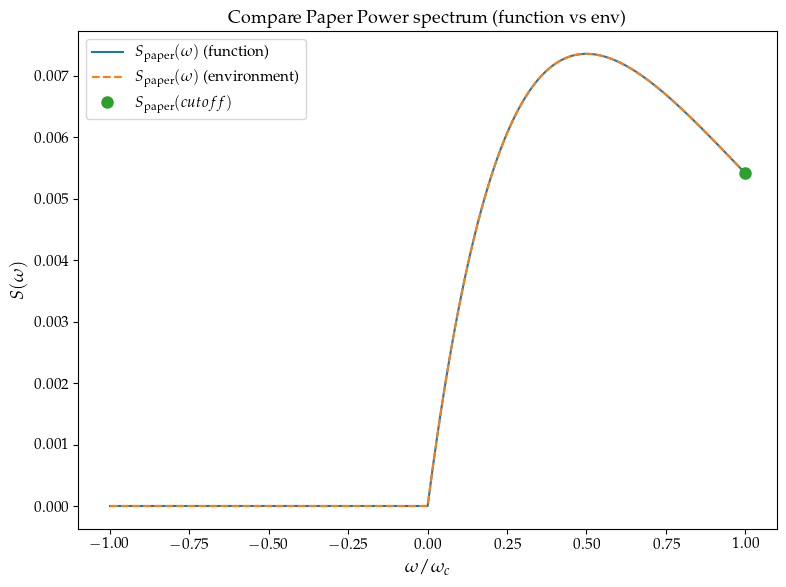

In [55]:
from qutip import BosonicEnvironment
import numpy as np
from qspectro2d.core.bath_system import (
    spectral_density_func_paper,
    power_spectrum_func_paper,
    power_spectrum_func_ohmic,
)

paper_bath = BosonicEnvironment.from_power_spectrum(
    lambda w: power_spectrum_func_paper(w, **args),
    wMax=10 * cutoff,  # Maximum frequency for the environment
    T=temp  # Temperature in Kelvin
)

ps_func = lambda w: power_spectrum_func_paper(w, **args)  # Direct function
ps_env = paper_bath.power_spectrum  # QuTiP environment

ps_env_0 = ps_env(0)   # Get power spectrum at zero frequency
ps_f_0 = ps_func(0)  # Calculate power spectrum at zero frequency

print("compare power spectrum at zero frequency:")
print(f"Paper Bath Power Spectrum at ω=0: {ps_env_0:.2e} (from environment)")
print(f"Paper Bath Power Spectrum at ω=0: {ps_f_0:.2e} (from function)")

import matplotlib.pyplot as plt
omega = np.linspace(-1 * cutoff, 1 * cutoff, 5001)
print(omega[len(omega) // 2])  # Print the center frequency (should be close to zero)
ps_func_vals = ps_func(omega)  # Direct function
ps_env_vals = ps_env(omega)  # QuTiP environment

plt.figure(figsize=(8, 6))
plt.plot(omega / cutoff, ps_func_vals, label=r"$S_{\mathrm{paper}}(\omega)$ (function)", color=COLORS[0], linestyle=LINE_STYLES[0])
plt.plot(omega / cutoff, ps_env_vals, label=r"$S_{\mathrm{paper}}(\omega)$ (environment)", color=COLORS[1], linestyle=LINE_STYLES[1])
plt.plot(1, ps_env(cutoff), 'o', label=r"$S_{\mathrm{paper}}(cutoff)$", markersize=8, color=COLORS[2])
plt.xlabel(r'$\omega / \omega_c$')  # Use LaTeX math formatting for Greek letters
plt.ylabel(r'$S(\omega)$')  # Example: update ylabel as well
plt.title(r'Compare Paper Power spectrum (function vs env)')  # Update title
plt.legend()

In [56]:
print("The power spectrum at w0 has value ", ps_env(w0), "and should be", ps_func(w0))
me_rates = paper_alpha_to_rate(alpha, env=paper_bath, w0=w0, mode="decay")
print(f"ME decay rates for Paper Bath (α={alpha}):")
print(f"  Emission Rate: {me_rates[0]}")
print(f"  Absorption Rate: {me_rates[1]}")

alpha_reconstructed = paper_rate_to_alpha(me_rates[0], env=paper_bath, w0=w0, wc=cutoff, mode="decay")
print(f"Reconstructed α from ME rates: {alpha_reconstructed} (should match original α={alpha})")

The power spectrum at w0 has value  0.0003920794693227021 and should be 0.0003920794693227021


NameError: name 'bath_to_rates' is not defined

In [ ]:
# DOES IT ALSO RESULT IN THE SAME EVOLUTION FOR THE PAPER-BATH
psi_ini    = (basis(2, 1) + basis(2, 0)).unit() # Initial state: excited state |e⟩⟨e|

tlist = np.linspace(0, 80, 10000) # Time array

a_ops_brme_paper  = [
    [sigma_z, lambda w: paper_bath.power_spectrum(w)], # Use sigma_z as system-bath coupling
    [sigma_x, lambda w: paper_bath.power_spectrum(w)], # Use sigma_x as system-bath coupling
]

result_brme = brmesolve(H0, psi_ini, tlist, a_ops_brme_paper)

# =============================
# MESOLVE SIMULATION
# =============================
### Extract power spectrum at system frequency
gamma_emission   = paper_alpha_to_rate(alpha, paper_bath, w0=w0, mode="decay")[0]  # Spontaneous emission rate
gamma_absorption = paper_alpha_to_rate(alpha, paper_bath, w0=w0, mode="decay")[1]  # Thermal absorption rate

gamma_deph = paper_alpha_to_rate(alpha, paper_bath, w0=w0, mode="deph")
### Collapse operators
c_ops_me_paper = [
    # decay
    gamma_emission * sigma_minus,    # Emission: |e⟩ → |g⟩
    gamma_absorption * sigma_plus,   # Absorption: |g⟩ → |e⟩
    # dephasing
    gamma_deph * sigma_z
]

result_me = mesolve(H0, psi_ini, tlist, c_ops_me_paper)

# =============================
# PLOT COMPARISON
# =============================
plt.figure(figsize=(10, 6))

# Plot excited state population for brmesolve
pop_brme = [state[1, 1].real for state in result_brme.states]
coh_brme = [state[0, 1].real for state in result_brme.states]  # Coherence |e><g|
plt.plot(tlist, pop_brme, label=r"BRMESOLVE: $\langle e|\rho|e\rangle$", color='C0', linestyle='solid')
plt.plot(tlist, coh_brme, label=r"BRMESOLVE: $\langle e|\rho|g\rangle$", color='C1', linestyle='solid')

# Plot excited state population for mesolve
pop_me = [state[1, 1].real for state in result_me.states]
coh_me = [state[0, 1].real for state in result_me.states]  # Coherence |e><g|
plt.plot(tlist, pop_me, label=r"MESOLVE: $\langle e|\rho|e\rangle$", color='C2', linestyle='dashed')
plt.plot(tlist, coh_me, label=r"MESOLVE: $\langle e|\rho|g\rangle$", color='C3', linestyle='dashed')

plt.xlabel(r"Time (arb. units)")
plt.ylabel(r"Excited State Population")
plt.title(r"Comparison: BRMESOLVE vs MESOLVE ($\sigma_x$ coupling, $\gamma = \sqrt{P(\omega_0)}$)")
plt.legend()
plt.tight_layout()
plt.show()

flat spectral density J(w)=gamma/2 and T=0-> definition of qutip -> S(w) = gamma theta(w)  [at w0 a transition rate of gamma]

the definition of the Ohmic bath in QuTiP is different fomr the paper:
factor 2

the coupling is always weak / strong with respect to the system frequency w0 -> weak 

In [ ]:
print("The power spectrum at w=0 has value ", ps_env(0), "and should be", ps_func(0))
me_rate = paper_alpha_to_rate(alpha, env=paper_bath, w0=w0, mode="deph")
print(f"ME dephasing rate for Paper Bath (α={alpha}):")
print(f"  Dephasing Rate: {me_rate}")

alpha_reconstructed = paper_rate_to_alpha(me_rate, env=paper_bath, w0=w0, wc=cutoff, mode="deph")
print(f"Reconstructed α from ME rate: {alpha_reconstructed} (should match original α={alpha})")

In [ ]:
tes_bath = OhmicEnvironment(
    T=temp, 
    wc=cutoff, 
    s=1.0, 
    alpha=alpha, 
    tag='ohmic'
)
w0 = 2  # System frequency in cm^-1
print("The power spectrum at w0 has value ", tes_bath.power_spectrum(w0))
me_rates = ohmic_alpha_to_rate(alpha, env=tes_bath, w0=w0, mode="decay")
print(f"ME decay rates for ohmic Bath (α={alpha}):")
print(f"  Emission Rate: {me_rates[0]}")
print(f"  Absorption Rate: {me_rates[1]}")

alpha_reconstructed = ohmic_rate_to_alpha(me_rates[0], env=tes_bath, w0=w0, wc=cutoff, mode="decay")
print(f"Reconstructed α from ME rates: {alpha_reconstructed} (should match original α={alpha})")

In [ ]:
print("The power spectrum at w=0 has value ", tes_bath.power_spectrum(0))
me_rate = ohmic_alpha_to_rate(alpha, env=tes_bath, w0=w0, mode="deph")
print(f"ME dephasing rate for ohmic Bath (α={alpha}):")
print(f"  Dephasing Rate: {me_rate}")

alpha_reconstructed = ohmic_rate_to_alpha(me_rate, env=tes_bath, w0=w0, wc=cutoff, mode="deph")
print(f"Reconstructed α from ME rate: {alpha_reconstructed} (should match original α={alpha})")

In [ ]:
reconstucted_bath = OhmicEnvironment(
    T=temp,
    wc=cutoff,
    s=1.0,
    alpha=alpha_reconstructed,
    tag='ohmic_reconstructed'
)
omega      = np.linspace(-2 * cutoff, 1 * cutoff, 5001)
def_vals    = tes_bath.power_spectrum(omega)  # Direct function
reconst_vals = reconstucted_bath.power_spectrum(omega)  # QuTiP environment

plt.figure(figsize=(8, 6))

plt.plot(omega, def_vals, label=r"$S_{\mathrm{ohm}}(\omega)$ (original)", color=COLORS[0], linestyle=LINE_STYLES[0])
plt.plot(omega, reconst_vals, label=r"$S_{\mathrm{ohm}}(\omega)$ (reconstructed)", color=COLORS[1], linestyle=LINE_STYLES[1])
plt.xlabel(r"$\omega / \omega_c$")
plt.ylabel(r"Power Spectrum $S(\omega)$")
plt.legend()

plt.show()

In [ ]:
# =============================
# SECULAR APPROXIMATION TESTS
# =============================
import time
from qutip import brmesolve, mesolve

### Test different secular approximation settings
print("="*60)
print("SECULAR APPROXIMATION COMPARISON TEST")
print("="*60)

# Test parameters - use existing system setup
test_tlist = np.linspace(0, 5, 50)  # Shorter time for faster testing

# Different secular approximation settings to test
sec_cutoffs = [
    -1,      # No secular approximation 
    0.01,    # Very strict approximation
    0.05,    # Strict approximation  
    0.1,     # Default approximation
    0.2,     # Relaxed approximation
    0.5      # Very relaxed approximation
]

# Storage for results and timing
results_dict = {}
timing_dict = {}

print(f"Testing with system frequency w0 = {w0}")
print(f"Bath temperature T = {temp}")
print(f"Bath cutoff frequency wc = {cutoff}")
print(f"Bath coupling strength α = {alpha}")
print("\n")

### Run tests for each secular cutoff
for i, sec_cutoff in enumerate(sec_cutoffs):
    print(f"Test {i+1}/6: sec_cutoff = {sec_cutoff}")
    
    if sec_cutoff == -1:
        print("  → No secular approximation (most accurate, slowest)")
    elif sec_cutoff <= 0.05:
        print("  → Very strict secular approximation")
    elif sec_cutoff <= 0.1:
        print("  → Standard secular approximation") 
    else:
        print("  → Relaxed secular approximation")
    
    # Time the calculation
    start_time = time.time()
    
    try:
        result = brmesolve(
            H=H0,
            psi0=psi_ini,
            tlist=test_tlist,
            a_ops=a_ops_brme,
            sec_cutoff=sec_cutoff,
            options={'store_states': True}
        )
        
        end_time = time.time()
        calc_time = end_time - start_time
        
        # Store results
        results_dict[sec_cutoff] = result
        timing_dict[sec_cutoff] = calc_time
        
        print(f"  ✓ Calculation completed in {calc_time:.3f} seconds")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        timing_dict[sec_cutoff] = None
        
    print()

print("="*60)
print("TIMING SUMMARY")
print("="*60)

# Display timing comparison
for sec_cutoff in sec_cutoffs:
    if timing_dict[sec_cutoff] is not None:
        if sec_cutoff == -1:
            label = "No secular (sec_cutoff = -1)"
        else:
            label = f"sec_cutoff = {sec_cutoff}"
        print(f"{label:25s}: {timing_dict[sec_cutoff]:6.3f} seconds")
    else:
        print(f"sec_cutoff = {sec_cutoff:5s}: FAILED")

# Calculate speedup factors
if timing_dict[-1] is not None:  # Reference: no secular approximation
    ref_time = timing_dict[-1]
    print(f"\nSpeedup factors (relative to no secular approximation):")
    for sec_cutoff in sec_cutoffs[1:]:  # Skip -1 as it's the reference
        if timing_dict[sec_cutoff] is not None:
            speedup = ref_time / timing_dict[sec_cutoff]
            print(f"  sec_cutoff = {sec_cutoff:5s}: {speedup:5.2f}x faster")
else:
    print("\nCannot calculate speedup factors (reference calculation failed)")

In [ ]:
# =============================
# VISUALIZATION OF SECULAR APPROXIMATION RESULTS
# =============================

### Plot excited state population for different secular approximations
plt.figure(figsize=(14, 10))

# Plot 1: Population dynamics comparison
plt.subplot(2, 2, 1)

for i, sec_cutoff in enumerate(sec_cutoffs):
    if sec_cutoff in results_dict:
        result = results_dict[sec_cutoff]
        pop = [state[1, 1].real for state in result.states]
        
        label = "No secular" if sec_cutoff == -1 else f"sec_cutoff = {sec_cutoff}"
        plt.plot(test_tlist, pop,
                label=label,
                color=COLORS[i % len(COLORS)],
                linestyle=LINE_STYLES[i % len(LINE_STYLES)])

plt.xlabel(r"Time (arb. units)")
plt.ylabel(r"Excited State Population $\langle e|\rho|e\rangle$")
plt.title("Population Dynamics: Secular Approximation Comparison")
plt.legend()

# Plot 2: Coherence dynamics comparison  
plt.subplot(2, 2, 2)

for i, sec_cutoff in enumerate(sec_cutoffs):
    if sec_cutoff in results_dict:
        result = results_dict[sec_cutoff]
        coh = [state[0, 1].real for state in result.states]
        
        label = "No secular" if sec_cutoff == -1 else f"sec_cutoff = {sec_cutoff}"
        plt.plot(test_tlist, coh,
                label=label,
                color=COLORS[i % len(COLORS)],
                linestyle=LINE_STYLES[i % len(LINE_STYLES)])

plt.xlabel(r"Time (arb. units)")
plt.ylabel(r"Coherence $\mathrm{Re}[\langle e|\rho|g\rangle]$")
plt.title("Coherence Dynamics: Secular Approximation Comparison")
plt.legend()

# Plot 3: Timing comparison
plt.subplot(2, 2, 3)

valid_cutoffs = [k for k in sec_cutoffs if timing_dict[k] is not None]
valid_times   = [timing_dict[k] for k in valid_cutoffs]
labels        = ["No secular" if k == -1 else f"{k}" for k in valid_cutoffs]

bars = plt.bar(range(len(valid_cutoffs)), valid_times, color=COLORS[2], alpha=0.7)
plt.xticks(range(len(valid_cutoffs)), labels, rotation=45)
plt.ylabel("Calculation Time (seconds)")
plt.title("Computation Time vs Secular Cutoff")

# Add value labels on bars
for bar, time_val in zip(bars, valid_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(valid_times)*0.01,
             f'{time_val:.3f}s', ha='center', va='bottom', fontsize=9)

# Plot 4: Error vs secular cutoff (if no secular approximation succeeded)
plt.subplot(2, 2, 4)

if -1 in results_dict:  # Reference calculation available
    ref_result = results_dict[-1]
    ref_pop = np.array([state[1, 1].real for state in ref_result.states])
    
    errors = []
    cutoff_labels = []
    
    for sec_cutoff in sec_cutoffs[1:]:  # Skip -1 as it's the reference
        if sec_cutoff in results_dict:
            result = results_dict[sec_cutoff]
            pop = np.array([state[1, 1].real for state in result.states])
            
            # Calculate RMS error
            rms_error = np.sqrt(np.mean((pop - ref_pop)**2))
            errors.append(rms_error)
            cutoff_labels.append(f"{sec_cutoff}")
    
    plt.semilogy(cutoff_labels, errors, marker='o', color=COLORS[3], linestyle=LINE_STYLES[1], markersize=6)
    plt.xlabel("Secular Cutoff")
    plt.ylabel("RMS Error (vs no secular)")
    plt.title("Accuracy vs Secular Cutoff")
    
    # Add error values as text
    for i, (label, error) in enumerate(zip(cutoff_labels, errors)):
        plt.text(i, error * 1.5, f'{error:.2e}', ha='center', va='bottom', fontsize=8)
        
else:
    plt.text(0.5, 0.5, 'Reference calculation\n(no secular) failed', 
             ha='center', va='center', transform=plt.gca().transAxes,
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
    plt.title("Error Analysis Not Available")

plt.tight_layout()
plt.show()

### Summary recommendations
print("="*60)
print("RECOMMENDATIONS")
print("="*60)

if timing_dict.get(-1) is not None and timing_dict.get(0.1) is not None:
    speedup = timing_dict[-1] / timing_dict[0.1]
    print(f"• Default setting (sec_cutoff = 0.1) provides {speedup:.1f}x speedup")
    
if (-1 in results_dict) and (0.1 in results_dict):
    ref_pop   = np.array([state[1, 1].real for state in results_dict[-1].states])
    approx_pop = np.array([state[1, 1].real for state in results_dict[0.1].states])
    error = np.sqrt(np.mean((approx_pop - ref_pop)**2))
    print(f"• Default setting introduces RMS error of {error:.2e}")

print("• For maximum accuracy: use sec_cutoff = -1 (no secular approximation)")
print("• For good balance of speed/accuracy: use sec_cutoff = 0.1 (default)")  
print("• For maximum speed: use sec_cutoff = 0.5 (may sacrifice accuracy)")
print("• Smaller cutoffs (0.01-0.05) are more accurate but slower")
print("• Larger cutoffs (0.2-0.5) are faster but less accurate")

In [ ]:
# =============================
# ADVANCED: PARAMETER DEPENDENCE STUDY
# =============================

### Test how secular approximation performance depends on system parameters
print("="*60)
print("PARAMETER DEPENDENCE OF SECULAR APPROXIMATION")
print("="*60)

# Test different coupling strengths
alpha_values = [0.01, 0.05, 0.1, 0.2]  # Different coupling strengths
sec_test = 0.1  # Use default secular approximation
sec_none = -1   # No secular approximation for comparison

print("Testing coupling strength dependence:")
print("(Comparing sec_cutoff = 0.1 vs no secular approximation)")
print()

for alpha_test in alpha_values:
    print(f"α = {alpha_test}:")
    
    # Create test bath with this coupling
    test_bath = OhmicEnvironment(T=temp, wc=cutoff, s=1.0, alpha=alpha_test)
    test_a_ops = [(sigma_x, test_bath)]
    
    # Time with secular approximation
    start_time = time.time()
    result_secular = brmesolve(H0, psi_ini, test_tlist, test_a_ops, sec_cutoff=sec_test)
    time_secular = time.time() - start_time
    
    # Time without secular approximation  
    start_time = time.time()
    result_nosec = brmesolve(H0, psi_ini, test_tlist, test_a_ops, sec_cutoff=sec_none)
    time_nosec = time.time() - start_time
    
    # Calculate speedup and accuracy
    speedup = time_nosec / time_secular
    
    pop_secular = np.array([state[1, 1].real for state in result_secular.states])
    pop_nosec = np.array([state[1, 1].real for state in result_nosec.states])
    rms_error = np.sqrt(np.mean((pop_secular - pop_nosec)**2))
    
    print(f"  Speedup: {speedup:.2f}x, RMS Error: {rms_error:.2e}")

print()

### Test different system frequencies
w0_values = [0.5, 1.0, 2.0, 5.0]  # Different system frequencies
print("Testing system frequency dependence:")
print()

for w0_test in w0_values:
    print(f"ω₀ = {w0_test}:")
    
    # Create new Hamiltonian with this frequency
    H_test = w0_test * 0.5 * sigma_z
    
    # Time with secular approximation
    start_time = time.time()
    result_secular = brmesolve(H_test, psi_ini, test_tlist, a_ops_brme, sec_cutoff=sec_test)
    time_secular = time.time() - start_time
    
    # Time without secular approximation
    start_time = time.time() 
    result_nosec = brmesolve(H_test, psi_ini, test_tlist, a_ops_brme, sec_cutoff=sec_none)
    time_nosec = time.time() - start_time
    
    # Calculate speedup and accuracy
    speedup = time_nosec / time_secular
    
    pop_secular = np.array([state[1, 1].real for state in result_secular.states])
    pop_nosec = np.array([state[1, 1].real for state in result_nosec.states])
    rms_error = np.sqrt(np.mean((pop_secular - pop_nosec)**2))
    
    print(f"  Speedup: {speedup:.2f}x, RMS Error: {rms_error:.2e}")

print()
print("="*60)
print("KEY INSIGHTS")
print("="*60)
print("• Secular approximation becomes more effective for:")
print("  - Weaker coupling (smaller α)")
print("  - Higher system frequencies (larger ω₀)")
print("  - Lower bath temperatures")
print("• When system frequencies >> bath correlation frequencies,")
print("  secular approximation is very accurate")
print("• For strong coupling or low frequencies, consider smaller")
print("  cutoffs or disable secular approximation entirely")
print("="*60)